## Introduction

### Motivation
Recent applications of GANs have shown that they can produce realistic samples. It was also shown that GANS can be applied for semi-supervised learning (SSL), which may improve accuracy of common classifiers. Besides, synthetic data can be labelled by a strong classifier and can be then extend the initial dataset. Since synthetically generated does not include patient data or privacy concerns, it will also allow medical institutions to share data they generate with other institutions, creating millions of different combinations that can be used to accelerate the work.

### Objectives
The first part of this research project was focused on implementation of a GAN model and on conducting initial results. Despite some limits of implemented model, the results were promising.

This part of the project will be concentrated on further improvement of the model. Besides, the main goal of this project is to implement and to compare different SSL models with the initial classifier.

### Dataset description
The GAN models were trained on PatchCamelyon ([PCam](https://github.com/basveeling/pcam)) dataset. PCam is derived from the Camelyon16 Challenge and contains 96x96px patches extracted from WSI. The dataset is divided into a training, a validation and test set. There is no overlap in WSIs between the splits, and all splits have a 50/50 balance between positive and negative examples. The dataset was also cleaned such that background and blurred patches were filtered out.

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. 

Since tumor tissue in the outer region of the patch does not influence the label, the patches were cropped to 64x64px for this project.


## Background

### GAN
GANs consist of two neural networks: Generator (G) and Discriminator (D). These networks are playing a minimax non-cooperative game against each other: G takes a random noise as input and tries to produce samples in such a way that D is unable to determine if they come from real dataset or it is generated images. D learns in a supervised manner by looking at real and generated samples and labels telling where those samples came from.

### Semi-supervised GAN
In the SSL approach, D plays two roles: it distinguishes between real and generated samples and classifies positive and negative examples from a real dataset. That is, both the classifier and the D share the same weights but have different outputs.

Since the classifier and D have the same wights, and D is trained on an unlabeled dataset (which can be larger than labeled one) and on generated images from G (which is getting better over the time), the classifier should also get better.

In this project, [CT-GAN](https://arxiv.org/abs/1606.01583) is used. It allows to connect [SSL approach](https://arxiv.org/pdf/1606.03498.pdf) with GAN.

### Methodology
#### Semi-supervised experiment
There are 3 different models: 2 SSL and one simple CNN classifier ([notebook](https://github.com/karray/pathology_gan/blob/master/clf_torch.ipynb)). 2 SSL models have a different generator architecture and are denoted as Good SSL ([notebook](https://github.com/karray/pathology_gan/blob/master/wgan_ct_ssl3.ipynb)) and Bad SSL ([notebook](https://github.com/karray/pathology_gan/blob/master/wgan_ct_ssl.ipynb)). These SSL models will be compared with the Classifier. The discriminator in both SSL models is the same and has almost the same architecture as the classifier. 

The training dataset was divided into 6 smaller parts:

1. 1% of the dataset
2. 10% of the dataset
3. 25% of the dataset
4. 50% of the dataset
5. 80% of the dataset
6. 100% of the dataset

Both the classifier and SSL models were trained on the same portion of data. Additionally, GAN in SSL model was trained on an unlabeled dataset, which is the whole training dataset.

#### Synthetic dataset experiment
In addition, the classifier was also trained on both fully generated and mixed datasets. Generated dataset was produced by [WGAN-GP](https://arxiv.org/abs/1704.00028) ([notebook](https://github.com/karray/pathology_gan/blob/master/wgan_gp_4.ipynb)). It was then classified by pre-trained classifier, in order to create labels. The final generated dataset contains of 262144 samples. The mixed dataset is a merge of generated and training datasets.

### Evaluation
<p style='color:#e55; font-weight: bold;'>Since the project is still in progress, the conducted results are preliminary</p>

The following chart compares the accuracy of the bad SSL model and the classifier for various portions of the training dataset:

![title](max_bad_ssl_vs_clf.png)

This chart compares good SSL model with bad SSL and classifier models:
![title](good_bad_ssl_vs_clf.png)


Finally, this chart compares classifiers trained on different datasets:

![title](clf_datasets.png)

Note that the classifier trained on the training data set was used to produce labels for the generated dataset.

Here is an example of synthetic data generated by WGAN-GP:

![title](wgan_gp_4_1261e.png)

### Preliminary conclusions
#### SSL results
Unfortunately, the SSL model does not demonstrate as good results as expected. But, despite a slight increase in accuracy, it is clear that this approach can improve a common classifier. As the project is still in progress, the results cannot be considered accurate.

Due to the lack of a detailed description of the CT-GAN SSL algorithm and its confusing [implementation](https://github.com/biuyq/CT-GAN/blob/master/CT-GANs/Theano_classifier/CT_CIFAR.py), it is currently difficult to say what is causing the poor accuracy improvement.

On the one hand, the problem may be that a different architecture is required for this particular task (i.e. ResNet for both G and D). On the other hand, my implementation may contain errors.

#### Synthetic dataset results
The classifier trained on the generated dataset shows promising results. It achieves almost the same accuracy as the pre-trained classifier. This indicates that synthetic data can easily be used to train other models if there is a good, pre-trained classifier that can produce accurate labels. The quality of the generated data can also be improved by introducing more advanced architectures such as ResNet.

The current implementation does not allow direct control of any features of the generated samples. The input feature vector will be randomly sampled from the normal distribution. However, since the data contains 2 different stains (hematoxylin and eosin (H&E)), the input vector can be easily extended by introducing a bit flags for each type of stain (see example below).

## Live example
Here is an example of pre-trained Keras model of WGAN-GP:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

wgan_gp = load_model('G_1950.h5')

#### Sample a latent feature vector from the normal distribution and generate an image:

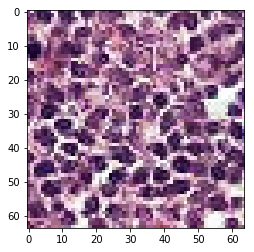

In [7]:
noise = np.random.normal(0,1,size=(1,100))
imgs = wgan_gp.predict(noise)

plt.imshow((imgs[0]*1* 127.5+127.5).astype(np.int32))

#### Here is an example of a tweaking a random feature. I picked the first one `noise[0]` and changed it from -1 to 1:

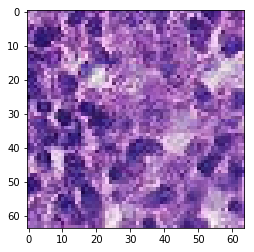

In [13]:
from IPython.display import clear_output

fig = plt.figure()

for feature in np.arange(-1,1,0.04):
    noise[0] = feature
    imgs = wgan_gp.predict(noise)
    plt.imshow((imgs[0]*1* 127.5+127.5).astype(np.int32))
    plt.show()
    # comment out the line below if the animation is not working
    clear_output(wait=True)